In [1]:
import pandas as pd
import mygene
import numpy as np
import seaborn as sns
from collections import defaultdict
from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet, cut_tree, set_link_color_palette
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm
from collections import Counter
from gprofiler import GProfiler
from matplotlib_venn import venn3

In [2]:
# load Hamming distance matrix

mat = pd.read_csv('hamming_distance_multilayer_network.tsv',sep='\t')
mat.rename(index={"APOPT1":84334, "ICK":22858, "KARS":3735})
mat.columns = mat.columns.astype(str)
mat.index = mat.columns.astype(str)

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load gene sets for each paediatric cancer

In [3]:
def entrez_convert(genes):
    mg = mygene.MyGeneInfo()
    entrez = mg.querymany(genes, scopes='symbol', species=9606, as_dataframe=True, verbose=False).reset_index()
    d = entrez[entrez['_id'].notna()].groupby('query')['_id'].apply(list).to_dict() # filter out genes with no Entrez ID and not in the multilayer network
    for k,v in d.items():
        j = [x for x in v if not x.startswith('ENSG')]
        if len(j) > 0:
            d[k] = j
        else:
            d[k] = ''
    genes = set([item for sublist in list(d.values()) for item in sublist])
    genes = set(genes).intersection(set(mat.index))
    return(genes)

# Medulloblastoma (Forget et al. 2018)

file_name = "mmc4.xlsx"

d = defaultdict(list)
def loadgenes(subgroup):
    df = pd.read_excel(file_name, sheet_name=subgroup+"-Ranking",engine='openpyxl')
    new_header = df.iloc[1]
    df = df[2:]
    df.columns = new_header
    for gene in df['Gene Name'].to_list():
        d[gene].append(subgroup)

for subgroup in tqdm(['WNT','SHH','G3','G4']):
    loadgenes(subgroup)
genes = set(d.keys())
print(len(genes),'MB genes in the original study')
genes_MB = entrez_convert(genes)
print(len(genes_MB),'MB genes in the multilayer')

# Neuroblastoma (Gartlgruber et al. 2021)

file_name = "43018_2020_145_MOESM3_ESM.xlsx"

df = pd.read_excel(file_name, sheet_name="Supplementary Table 3",engine='openpyxl')
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df = df[['target SYMBOL','Signature ChIPseq MaxExposure']].dropna().drop_duplicates()
genes = set(df['target SYMBOL'].to_list())
print(len(genes),'NB genes in the original study')
genes_NB = entrez_convert(genes)
print(len(genes_NB),'NB genes in the multilayer')

# Ewing's sarcoma (Tirode et al. 2014)

file_name = "NIHMS628157-supplement-5.xlsx"

df = pd.read_excel(file_name, sheet_name="Supplementary Table 3",engine='openpyxl')
new_header = df.iloc[1]
df = df[2:]
df.columns = new_header
genes = set(df['#Gene'].to_list())
print(len(genes),'ES genes in the original study')
genes_ES = entrez_convert(genes)
print(len(genes_ES),'ES genes in the multilayer')

100%|██████████| 4/4 [00:14<00:00,  3.64s/it]


3838 MB genes in the original study
3677 MB genes in the multilayer
1476 NB genes in the original study
1153 NB genes in the multilayer
50 ES genes in the original study
46 ES genes in the multilayer


## Clustering of multilayer community trajectories

### Relaxed criterion (similar trajectories)

In [4]:
def relaxed_clustering(genes):

    new_mat = mat.loc[genes][genes]

    lst = []
    for i in ['complete','single','average','weighted','centroid','median','ward']:
        Z = linkage(squareform(new_mat), i)
        lst.append([i,cophenet(Z,squareform(new_mat))[0]])

    ccc = pd.DataFrame.from_records(lst)
    ccc.columns = ['linkage method','cophenetic correlation']
    ccc = ccc.sort_values(by=['cophenetic correlation'], ascending=False)
    print(ccc)
    lm = ccc[ccc['cophenetic correlation']==max(ccc['cophenetic correlation'])]['linkage method'].values[0]
    print('optimal linkage methods:',lm)

    Z = linkage(squareform(new_mat), lm) # linkage function takes condensed matrix (upper triangular part)

    # optimal number of clusters

    lst = []
    heights = set(Z[:,2])
    for t in tqdm(range(1,1000)):
        clusters = fcluster(Z, t, criterion='maxclust')
        if len(set(clusters)) > 1:
            ch = calinski_harabasz_score(new_mat, clusters)
        else:
            ch = np.nan
        lst.append([t,ch])

    df_oc = pd.DataFrame.from_records(lst)
    df_oc.columns = ['num_clusters','calinski_harabasz']
    df_oc = df_oc.sort_values('calinski_harabasz')
    t = min(df_oc[df_oc['calinski_harabasz']==max(df_oc['calinski_harabasz'])]['num_clusters'].values)
    print('optimal numer of clusters:',t)

    # clusters membership dictionary

    clusters = fcluster(Z, t, criterion='maxclust')
    d = defaultdict(list) 
    for i in enumerate(clusters):
        d[i[1]].append(new_mat.index[i[0]])

    # clusters stats

    lst = []
    for k,v in d.items():
        if len(v)>1:
            lst.append(len(v))
    print('num cluster with >1 member:',len(lst))
    print('mean num genes per cluster:',np.mean(lst))
    
    # plot CH scores and barplots
    fig, ax =plt.subplots(1,2,figsize=(25, 10))
    sns.set(font_scale=1.4)
    p1 = sns.lineplot(data=df_oc, x="num_clusters", y="calinski_harabasz", ax=ax[0])
    p1.set_xlabel("Number of clusters", fontsize = 20)
    p1.set_ylabel("Calinski-Harabasz score", fontsize = 20)
    p2 = sns.histplot(lst, ax=ax[1])
    p2.set_xlabel("Number of genes per cluster", fontsize = 20)
    p2.set_ylabel("Count", fontsize = 20)
    fig.show()

    # plot dendrogram
    fig = plt.figure(figsize=(25, 10))
    cmap = cm.rainbow(np.linspace(0, 1, t))
    cols = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
    set_link_color_palette(list(set(cols)))
    dn = dendrogram(Z, color_threshold=0.0)
    plt.show()
    
    return(d)

Medulloblastoma
  linkage method  cophenetic correlation
2        average                0.925814
3       weighted                0.881091
0       complete                0.833836
4       centroid                0.766198
5         median                0.557000
1         single                0.475755
6           ward                0.316362
optimal linkage methods: average


100%|██████████| 999/999 [03:36<00:00,  4.61it/s]


optimal numer of clusters: 5
num cluster with >1 member: 5
mean num genes per cluster: 735.4


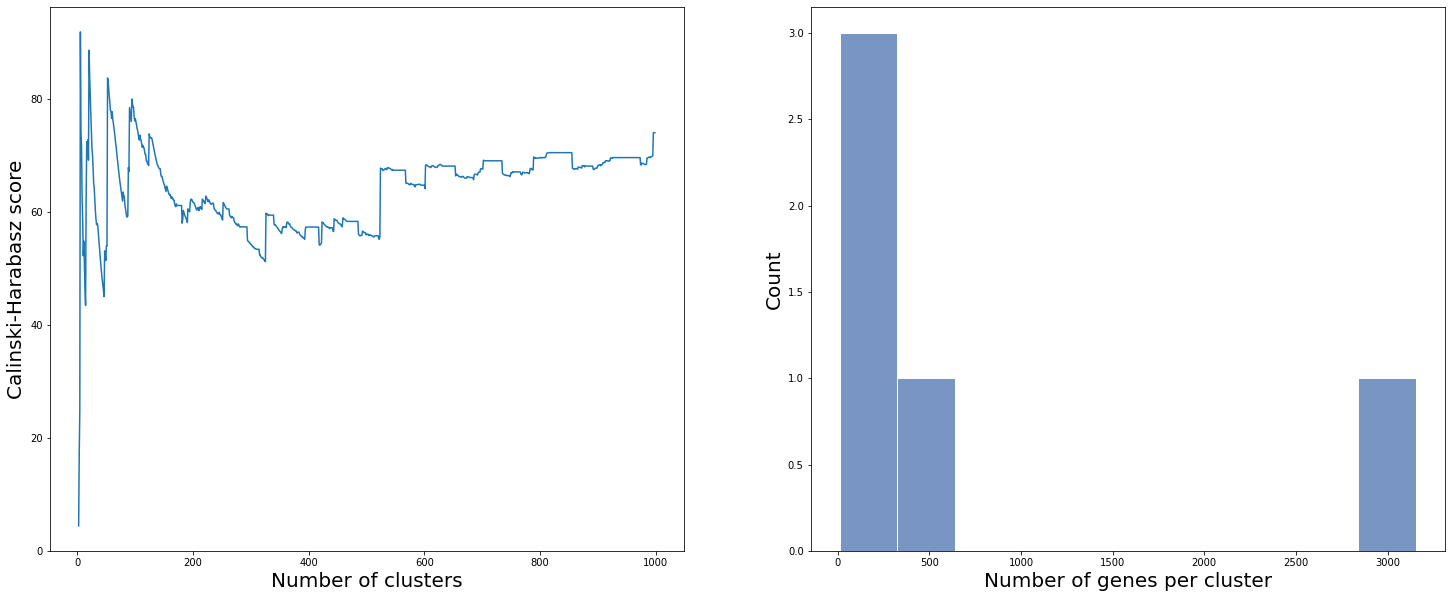

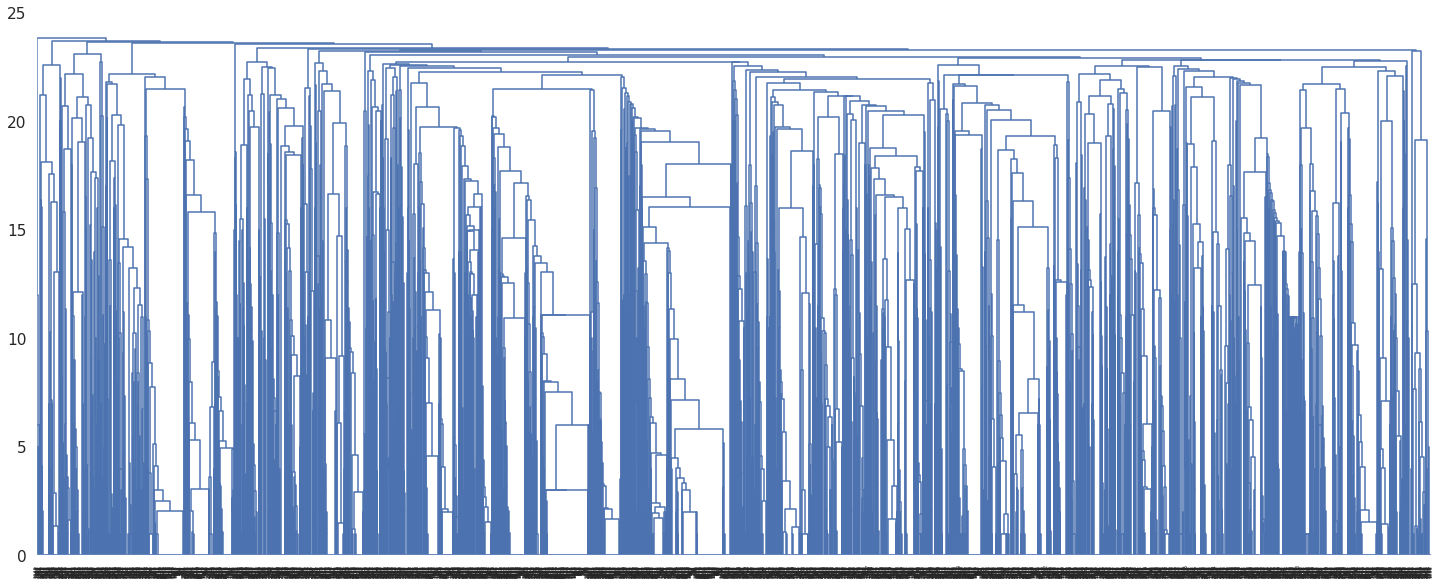

Neuroblastoma
  linkage method  cophenetic correlation
2        average                0.886955
3       weighted                0.854475
0       complete                0.814977
4       centroid                0.696382
5         median                0.514791
1         single                0.436420
6           ward                0.343014
optimal linkage methods: average


100%|██████████| 999/999 [00:36<00:00, 27.32it/s]


optimal numer of clusters: 740
num cluster with >1 member: 139
mean num genes per cluster: 3.971223021582734


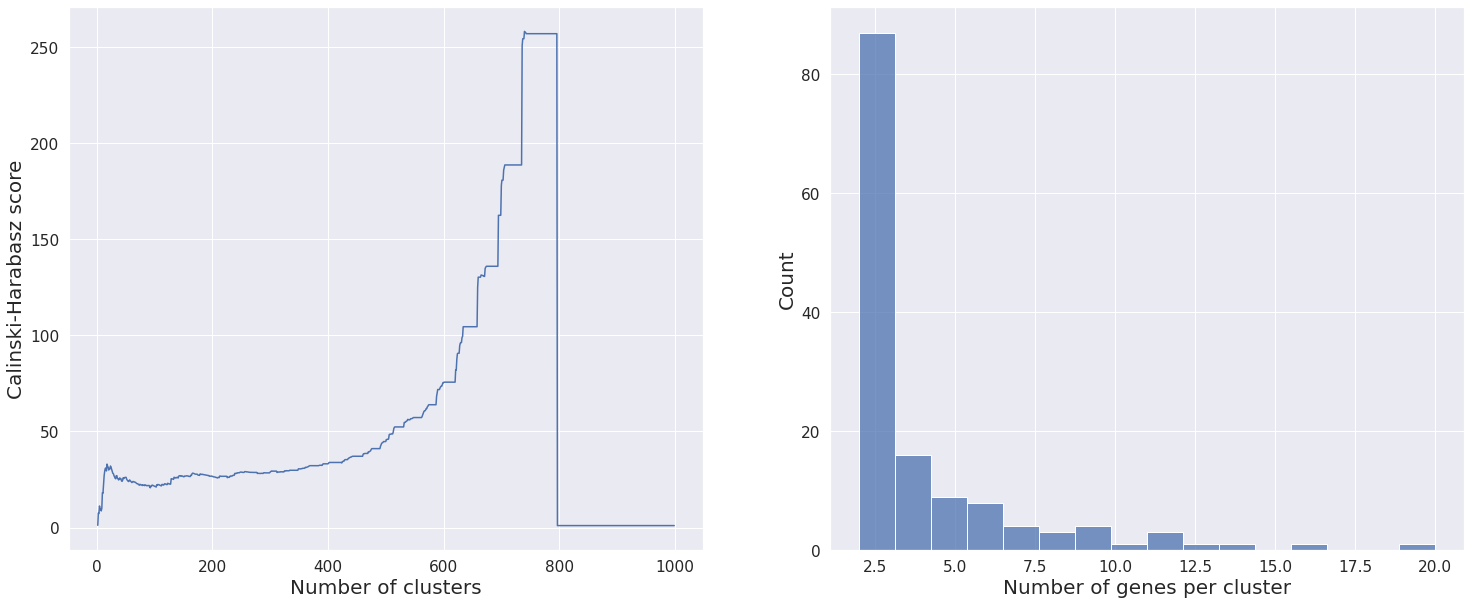

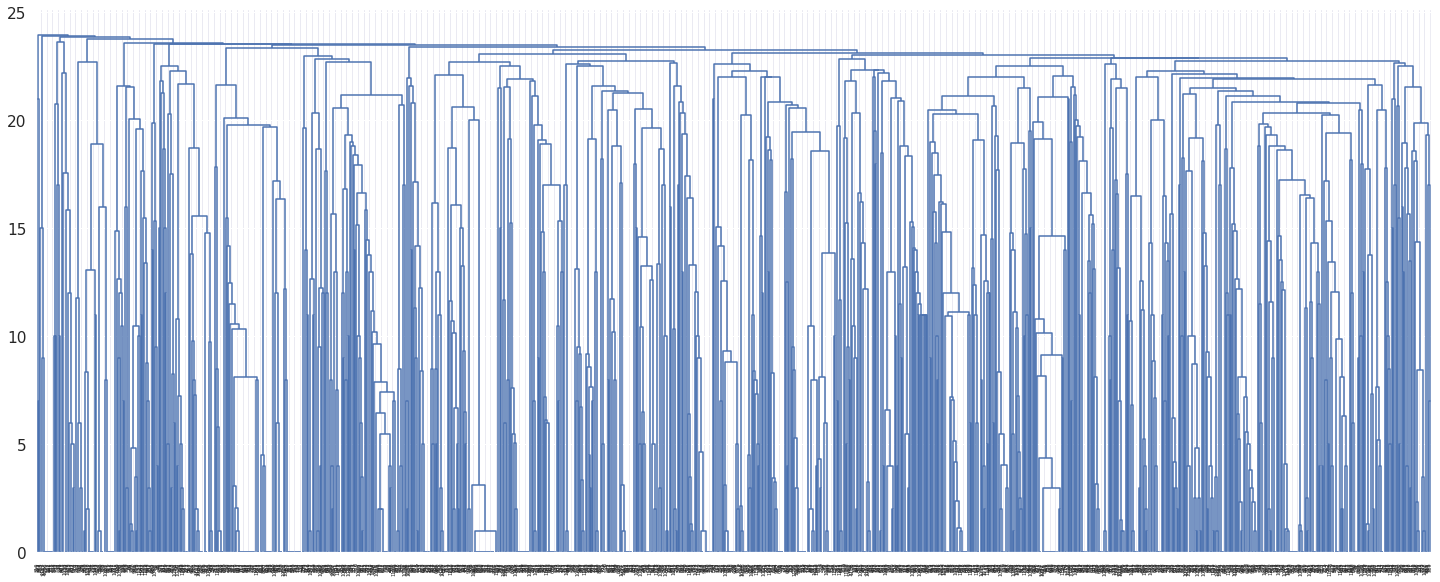

Ewing's sarcoma
  linkage method  cophenetic correlation
2        average                0.989863
3       weighted                0.989561
0       complete                0.984966
1         single                0.969303
4       centroid                0.928789
5         median                0.867300
6           ward                0.599341
optimal linkage methods: average


100%|██████████| 999/999 [00:02<00:00, 399.99it/s]


optimal numer of clusters: 39
num cluster with >1 member: 4
mean num genes per cluster: 2.75


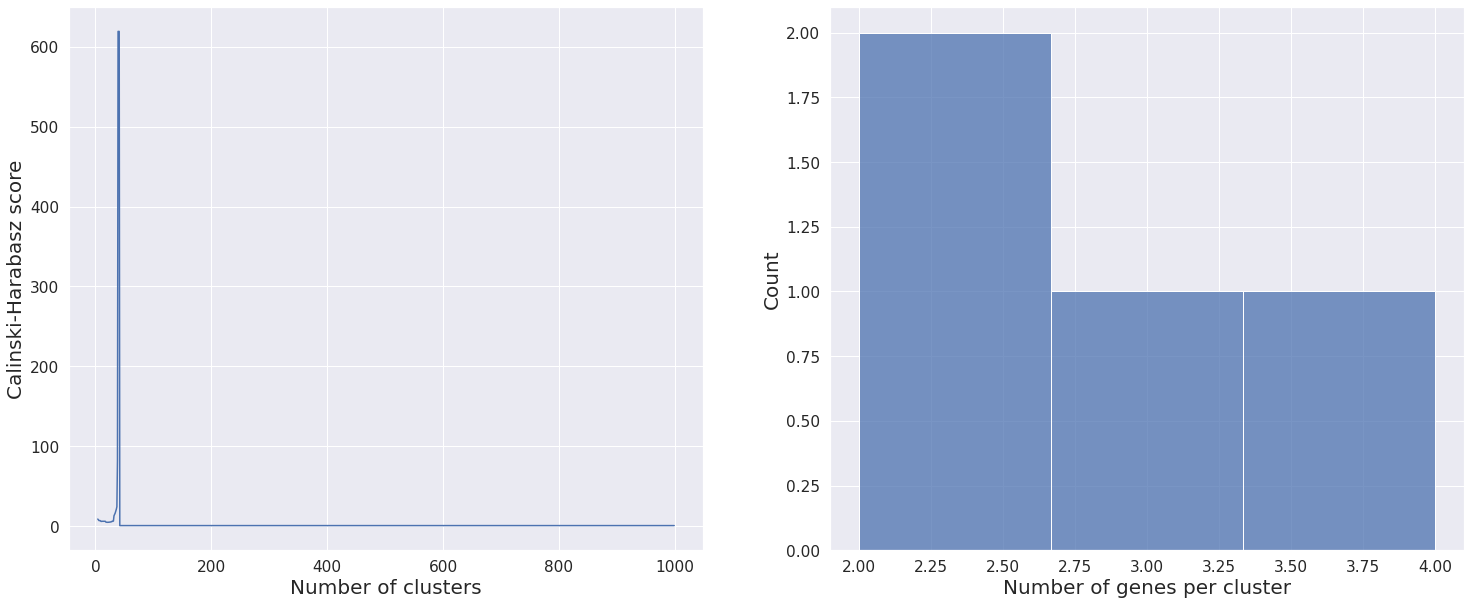

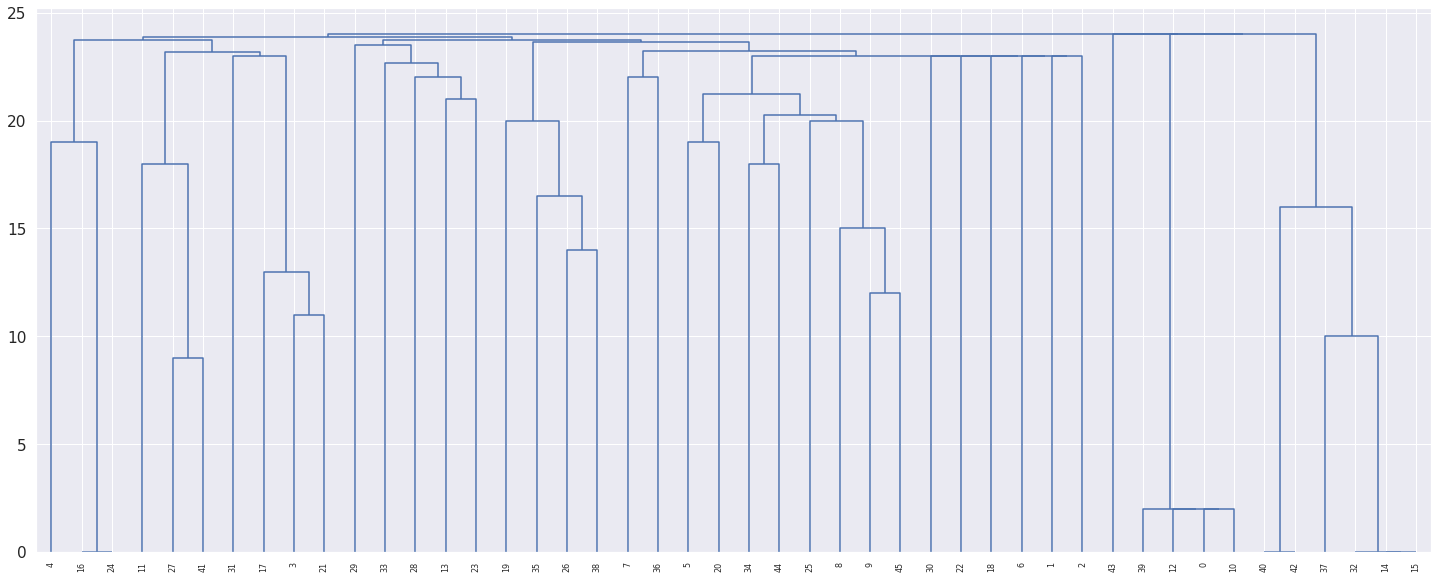

In [5]:
print("Medulloblastoma")
d_MB = relaxed_clustering(genes_MB)
print("Neuroblastoma")
d_NB = relaxed_clustering(genes_NB)
print("Ewing's sarcoma")
d_ES = relaxed_clustering(genes_ES)

### Strict criterion (identical trajectories)

In [6]:
comm = "data/multilayer_network/precomputed_stuff/gene_community_matrix__multilayer_network.tsv"
comm_df = pd.read_csv(comm,sep='\t')
comm_df.columns = [i.split('data/Molti_Output/')[1].split('.csv')[0] for i in comm_df.columns]

def strict_clustering(genes):
    comm = comm_df.loc[genes]
    comm['trajct'] = [comm.iloc[i,:].to_string(index=False, header=False).replace('\n','_').replace(' ', '') for i in range(len(comm.index))]
    comm['genes'] = comm.index
    comm_d = comm.groupby('trajct')['genes'].apply(list).to_dict()
    
    # clusters stats

    lst = []
    for k,v in comm_d.items():
        if len(v)>1:
            lst.append(len(v))
    print('num cluster with >1 member:',len(lst))
    print('mean num genes per cluster:',np.mean(lst))
    
    return(comm_d)

print("Medulloblastoma")
d_MB = strict_clustering(genes_MB)
print("Neuroblastoma")
d_NB = strict_clustering(genes_NB)
print("Ewing's sarcoma")
d_ES = strict_clustering(genes_ES)

Medulloblastoma
num cluster with >1 member: 274
mean num genes per cluster: 6.890510948905109
Neuroblastoma
num cluster with >1 member: 124
mean num genes per cluster: 3.870967741935484
Ewing's sarcoma
num cluster with >1 member: 3
mean num genes per cluster: 2.3333333333333335


## Functional enrichment analysis

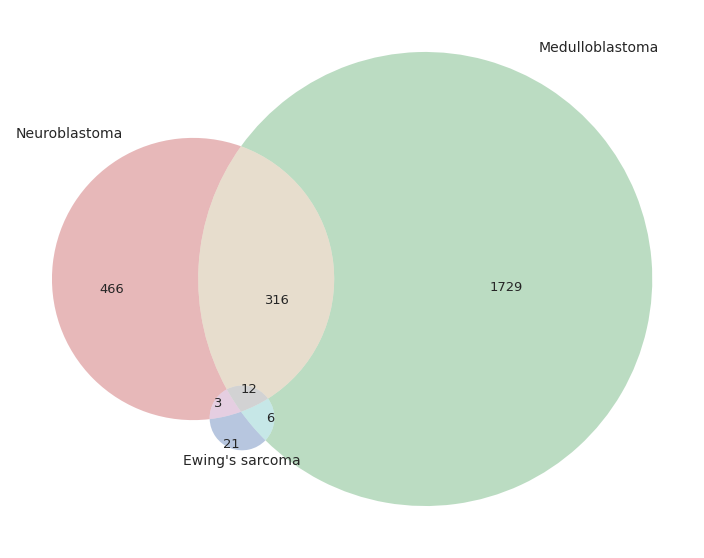

In [7]:
plt.rcParams['figure.figsize'] = [15, 10]
vd3=venn3([set(d_NB.keys()),set(d_MB.keys()),set(d_ES.keys())],
          set_labels=('Neuroblastoma','Medulloblastoma','Ewing\'s sarcoma'))
for t in vd3.set_labels: t.set_fontsize(14)
for t in vd3.subset_labels: t.set_fontsize(13)
plt.show()

In [8]:
# GO enrichments of common clusters

def gprofile(genes, tag):
    gp = GProfiler(return_dataframe=True)
    gp_res = gp.profile(organism='hsapiens', query=genes, no_iea = True, sources = ['GO'],
                        user_threshold = 0.05, significance_threshold_method = 'bonferroni', no_evidences=False,
                        domain_scope = 'annotated')
    gp_res['cluster'] = tag
    return(gp_res[gp_res['intersection_size']>3][['source','native','name','p_value','cluster','term_size','query_size','intersection_size','effective_domain_size','precision','recall']])

common_clusts = set(d_NB.keys()).intersection(set(d_MB.keys())).intersection(set(d_ES.keys()))
lst = []
for i in enumerate(common_clusts):
    clust = i[1]
    tag = i[0]
    lst.append([tag,d_NB[clust],d_MB[clust],d_ES[clust]])
df = pd.DataFrame.from_records(lst)
df.columns = ['cluster ID','NB','MB','ES']

lst_GO = []
for i in enumerate(common_clusts):
    clust = i[1]
    tag = i[0]
    lst_GO.append(gprofile(list(set([item for sublist in list(df[['NB','MB','ES']].loc[tag]) for item in sublist])),tag))
pd.concat(lst_GO).to_csv('output/clusters_GO_enrichments.tsv',index=None,sep='\t')

mg = mygene.MyGeneInfo()
def entrez2symbol(tag):
    lst = []
    for i in tqdm(df[tag]):
        gp = mg.querymany(i, scopes='entrezgene', species=9606, as_dataframe=True, verbose=False).reset_index()['symbol'].to_list()
        lst.append(";".join(gp))
    df[tag] = lst

for i in ['NB','MB','ES']:
    entrez2symbol(i)

df.to_csv('output/clusters_genes.tsv',index=None,sep='\t')
df

100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


,cluster ID,NB,MB,ES
0,0,ASTN2;KLHDC8A;RASSF3;PDCL3;STRIP1;CDCA4;STK24,TCP1;CCT3;STRIP1;CCT5;CCT7;CCT4;STRN4;MOB4;TTC...,STRN4
1,1,SIGLEC10;CD1D,CXADR,TREML1
2,2,PRLHR;HRH1,GNA11;GNAQ;NLN,OXTR
3,3,AGBL4;TBCD,TUBB2A;TBCC;TTC5;TUBB6;TUBB4B;TUBB3;TUBB4A;TBC...,AGBL1
4,4,SORL1,TGFBI,APCS
5,5,NPY;GAL;APLNR;CXCR4;GRM8;GPR18;GNAZ,HEBP1;GPSM1,GRM4
6,6,DLC1;ODC1;CCND1;TRIM67,CTNNB1;PTPN12;BAX;SRC,TP53
7,7,ARHGAP28;IRS2;SOX11;TCF7L2;PAX4,IGF2BP2;APPL1;HMGA1;PTPN1;IRS1,PCDHB10
8,8,SPRY1;HPCAL1;CD164;CREB5;DAAM2;SPRY2;KRT19,GLRX3;KRT8;CAPNS1;KRT15;DSG2;HPCAL1;KRT18,LCE1C;KRT38
9,9,ANK2;KCNH2;MYL4;DPP6;RYR2;RYR3;CACNA1C;SCN5A,ANK2;GPD1L;AKAP9;NUP155;GNAI2,NUP155;DPP10;KCNIP1
